# 10 Step Phase Shifting Technique

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from functions import mask_circ_img, load_raw_img, rad_to_deg
from unwrapping_isoclinic import phase_unwrap_isoclinic
from unwrapping_algorithm import phase_unwrap

### Load the 10 images

In [4]:
base_path = "img/inputs/ring/phase-shifting/"
file_type = ".CR2"

file_names = os.listdir(base_path)

imgs = []

for file_name in file_names:
    imgs.append(load_raw_img(base_path + file_name)[:,:,1] / 10)

In [5]:
alphas = rad_to_deg(np.array([
    np.pi / 2, 
    5*np.pi/8, 
    3*np.pi/4, 
    7*np.pi/8, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2
]))

betas = rad_to_deg(np.array([
    0,
    np.pi/8,
    np.pi/4,
    3*np.pi/8,
    np.pi/2,
    0,
    0,
    np.pi/4,
    0,
    np.pi/2
]))

for i in range(len(alphas)):
    print(f'Alpha: {alphas[i]}, Beta: {betas[i]}')

Alpha: 90.0, Beta: 0.0
Alpha: 112.5, Beta: 22.5
Alpha: 135.0, Beta: 45.0
Alpha: 157.5, Beta: 67.5
Alpha: 90.0, Beta: 90.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 45.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 90.0


### Calculate the isoclinic parameter
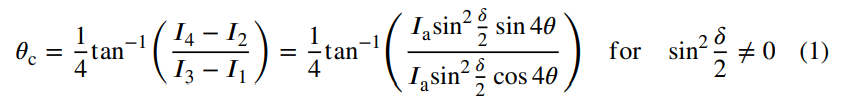

In [6]:
def generate_isoclinic_param(
        img_1: np.ndarray, 
        img_2: np.ndarray, 
        img_3: np.ndarray, 
        img_4: np.ndarray
) -> np.ndarray:
    """
    Images should be in order defined by Ramesh et al. 
    Returns the isoclinic parameter
    """
    return 1/4 * np.arctan2((img_4 - img_2),(img_3 - img_1))

In [7]:
isoclinic_param = generate_isoclinic_param(imgs[0], imgs[1], imgs[2], imgs[3])

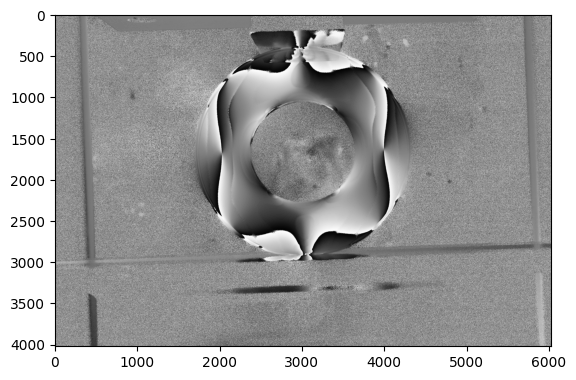

In [8]:
plt.imshow(isoclinic_param, cmap='gray')

In [9]:
filename = 'img/results/ring_isocl_wr.jpg'
plt.imsave(filename, isoclinic_param, cmap='gray')


In [10]:
img = cv.medianBlur(cv.imread(filename, cv.IMREAD_GRAYSCALE), 5) 

In [11]:
# Set stack as isotropic points
stack = [(2200, 2200), (2200, 2000), (1100, 2200), (1100, 2000), (1100, 3700), (2300, 3700), (1700, 2100)]

#create dummy array to be populated by unwrapped pixels
dummy = cv.imread('img/masks/ring_mask.jpg', cv.IMREAD_GRAYSCALE)
dummy = dummy.astype(float)
    # None outside the mask, np.inf inside the mask
dummy[dummy == 0] = -np.inf
dummy[dummy == 255] = np.inf

isoclinic_unwrapped = phase_unwrap_isoclinic(img, stack, dummy)


143 241
0 7
300000 3764
600000 4867
900000 5511
1200000 5735
1500000 5471
1800000 5263
2100000 3848
2400000 3116
2700000 2870
3000000 2807
3300000 2305
3600000 1580


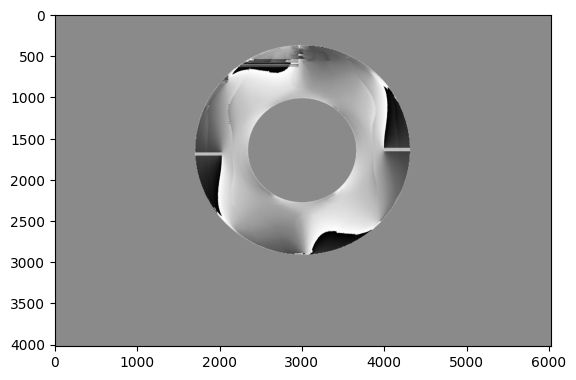

In [12]:
plt.imshow(isoclinic_unwrapped, cmap='gray')

### Generate isochromatic parameter
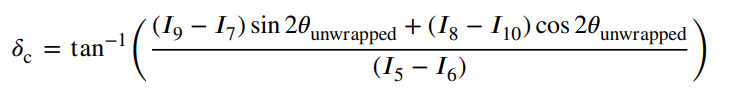


In [13]:
def generate_isochromatic_param(
    img_5: np.ndarray,
    img_6: np.ndarray,
    img_7: np.ndarray,
    img_8: np.ndarray,
    img_9: np.ndarray,
    img_10: np.ndarray,
    isoclinic_param: np.ndarray
) -> np.ndarray:
    return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) + 
                      (img_8 - img_10)*np.cos(2*isoclinic_param))/(img_5 - img_6))

In [14]:
isochromatic_param_rad = np.nan_to_num(generate_isochromatic_param(
    imgs[4],
    imgs[5],
    imgs[6],
    imgs[7],
    imgs[8],
    imgs[9],
    isoclinic_unwrapped
))

C:\Users\fredd\AppData\Local\Temp\ipykernel_18956\3016659149.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +
C:\Users\fredd\AppData\Local\Temp\ipykernel_18956\3016659149.py:10: RuntimeWarning: invalid value encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +


Translate `isochromatic_param` values from `(-pi/2, pi/2)` to `(0, 255)`

In [15]:
isochromatic_param = (isochromatic_param_rad + np.pi/2)*255/(np.pi)

## Isochromatic Image Processing

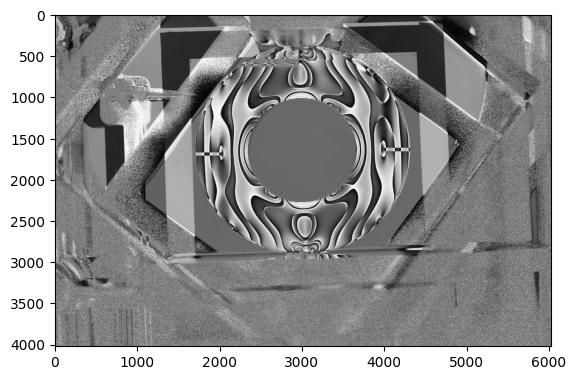

In [16]:
plt.imshow(isochromatic_param, cmap='gray')

In [17]:
# Save the image
filename = 'img/results/ring_isoch_wr_isoc_unwr.jpg'
plt.imsave(filename, isochromatic_param, cmap='gray')

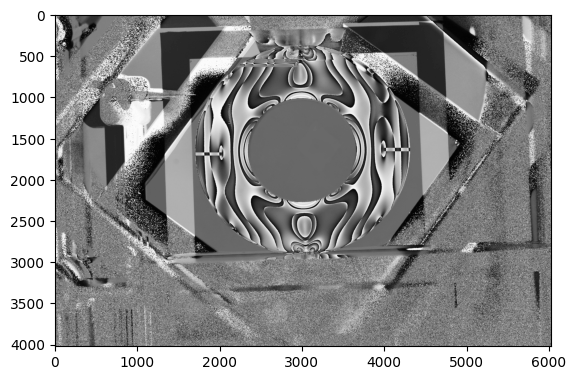

In [18]:
img = cv.medianBlur(cv.imread(filename, cv.IMREAD_GRAYSCALE), 5) 
plt.imshow(img, cmap='gray')

In [19]:
# Set stack as isotropic points
stack = []
#create dummy array to be populated by unwrapped pixels
dummy = np.zeros(img.shape)
dummy[:,:] = -1
# None outside the mask, np.inf inside the mask
cv.circle(dummy, centre, radius, np.inf, -1)

isochromatic_unwrapped = phase_unwrap(img, stack, centre, radius, dummy)

plt.imshow(isochromatic_unwrapped, cmap='gray')
filename = 'img/results/disc_isochr_unwr_isoc_unwr.jpg'
plt.imsave(filename, isochromatic_unwrapped, cmap='gray')


NameError: name 'centre' is not defined

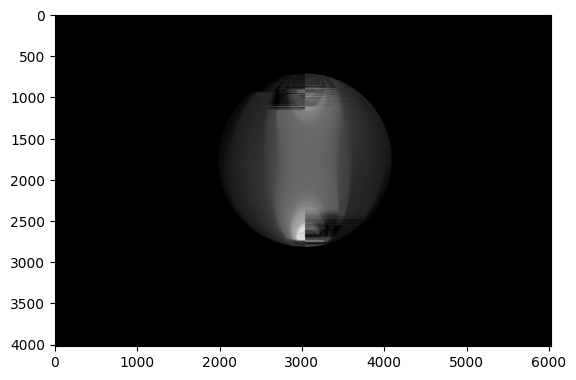

In [ ]:
# Load the image back in
img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
img_masked = mask_circ_img(img, (3030, 1770), 1050)
plt.imshow(img, cmap='gray')
plt.imsave('img/results/disc_isochr_unwr_isoc_unwr_mask.jpg', img, cmap='gray')